## Imports

In [ ]:
import numpy as np
import torch
from sklearn.model_selection import ParameterGrid
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import classification_report, accuracy_score, f1_score
from torch.optim import Adam
from sklearn.preprocessing import LabelEncoder
import gensim
import gensim.downloader as api
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, auc
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.dummy import DummyClassifier

from tqdm import tqdm
import nltk
nltk.download('punkt_tab')
from nltk.help import upenn_tagset
from nltk.corpus import stopwords
from tensorflow.keras.datasets import imdb
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')
from nltk.tag.perceptron import PerceptronTagger
from nltk.stem import WordNetLemmatizer

import warnings
warnings.filterwarnings("ignore")

import re
from collections import Counter, defaultdict
from scipy.stats import uniform
from statistics import mode

import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import numpy as np
from collections import defaultdict, Counter
import pyconll
import time
import os

2024-12-11 15:49:49.064922: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-11 15:49:49.149563: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-12-11 15:49:49.149577: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-12-11 15:49:49.170281: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-11 15:49:49.617348: W tensorflow/stream_executor/platform/de

## Preliminaries

In [ ]:
class UtilsPOSTagging:

    @staticmethod
    def parse_conllu(path):
        """
        Processes .conllu files to extract relevant linguistic information:
        - For each sentence:
        - Each token is checked for the presence of a valid word form (token.form) and POS tag (token.upos).
        - If both are present, the word form (converted to lowercase) and its corresponding POS tag are stored in a tuple.
        - Only non-empty sentences are added to the output.
        It returns a list of sentences, where each sentence is represented as a list of (word, POS tag) tuples.
        """

        data = pyconll.load_from_file(path)
        print(f"Loaded {len(data)} sentences from {path}")
        tagged_sentences = []

        for sentence in data:
            tagged_sentence = []
            for token in sentence:
                if token.form and token.upos:  # Ensure both form and UPOS are valid
                    tagged_sentence.append((token.form.lower(), token.upos))
            if tagged_sentence:  # Skip empty sentences
                tagged_sentences.append(tagged_sentence)
        return tagged_sentences

    @staticmethod
    def calculate_statistics(tagged_sentences, title):
        num_sentences = len(tagged_sentences)
        num_words = sum(len(sentence) for sentence in tagged_sentences)
        avg_sentence_length = num_words / num_sentences if num_sentences > 0 else 0

        stats =  {
            "num_sentences": num_sentences,
            "num_words": num_words,
            "avg_sentence_length": avg_sentence_length,
        }

        # Print statistics
        print(f"{title} Data Statistics:")
        print(f"  Number of Sentences: {stats['num_sentences']}")
        print(f"  Number of Words: {stats['num_words']}")
        print(f"  Average Sentence Length: {stats['avg_sentence_length']:.2f}\n")

        return stats

    def sliding_window(sentences_as_words, sentences_as_tags, window_size=3, embedding_dim=300):
        """
        Generate features and labels for an MLP model using sliding window word embeddings.

        Parameters:
            sentences_as_words (list of lists): Word embeddings for each sentence.
            sentences_as_tags (list of lists): Corresponding POS tags for each word in the sentences.
            window_size (int): Size of the sliding window (default is 3).
            embedding_dim (int): Dimensionality of the word embeddings (default is 300).

        Returns:
            np.array: Feature vectors for the MLP model (flattened sliding windows).
            np.array: Corresponding labels (POS tags for the center words).
        """
        padding_value = np.zeros(embedding_dim)
        features = []
        tags = []

        for words, pos_tags in zip(sentences_as_words, sentences_as_tags):
            # Pad embeddings and tags at both ends
            pad_size = window_size // 2
            padded_words = [padding_value] * pad_size + words + [padding_value] * pad_size
            padded_tags = [None] * pad_size + pos_tags + [None] * pad_size

            # Sliding window over the padded sentence
            for i in range(pad_size, len(padded_words) - pad_size):
                # Extract the sliding window of embeddings
                window = padded_words[i - pad_size:i + pad_size + 1]
                features.append(np.concatenate(window))  # Flatten the window
                tags.append(padded_tags[i])  # Center word's POS tag

        return np.array(features), np.array(tags)

    @staticmethod
    def get_word_embedding(word, model, embedding_dim = 300):
        """
        Retrieves a word's embedding from a pre-trained model, returning a zero vector if the word is not in the model's vocabulary.
        """
        try:
            return model[word]
        except KeyError:
            return np.zeros(embedding_dim)

    @staticmethod
    def tags(sentences):
        """Extracts POS tags from sentences."""
        return [[tag for _, tag in sentence] for sentence in sentences]

    @staticmethod
    def words(sentences):
        """Extracts words from sentences."""
        return [[word for word, _ in sentence] for sentence in sentences]

    @staticmethod
    def map_tags_to_numbers(tags, tag_to_int):
        return [tag_to_int[tag] for tag in tags]

In [ ]:
class Report:

    @staticmethod
    def plot_training_history(history):
        # Plotting loss
        plt.figure()
        plt.plot(history['train_loss'], label='Training Loss')
        plt.plot(history['val_loss'], label='Validation Loss')
        plt.title('Loss Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        # Plotting accuracy
        plt.figure()
        plt.plot(history['train_accuracy'], label='Training Accuracy')
        plt.plot(history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

        # Plotting F1 score
        plt.figure()
        plt.plot(history['train_f1_score'], label='Training F1 Score')
        plt.plot(history['val_f1_score'], label='Validation F1 Score')
        plt.title('F1 Score Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('F1 Score')
        plt.legend()
        plt.show()


    @staticmethod
    def display_metrics_scores(estimators, classes, datasets, class_names):
        """
        Displays the evaluation metrics (precision, recall, F1, PR-AUC) for multiple classifiers across
        different data subsets (Train, Dev, Test) in a styled table format, with class names displayed.

        Parameters:
        - estimators: Dictionary of classifiers
        - classes: List of numerical class labels
        - datasets: Dictionary of data subsets (Train, Dev, Test)
        - class_names: Dictionary mapping class numbers to class names
        """
        # inverted_class_names = {v: k for k, v in class_names.items()}
        def style_results(results, subset_name):
            combined_df = pd.concat(results, ignore_index=True)

            # combined_df['Class'] = combined_df['Class'].replace(inverted_class_names)
            combined_df['Class'] = combined_df['Class']

            # Style and format the table
            styled = combined_df.style.set_properties(
                subset=pd.IndexSlice[combined_df['Classifier'].duplicated(keep='first') == False, :],
                **{'border-top': '3px solid black'}
            ).set_table_styles([
                {'selector': 'th', 'props': [('text-align', 'center')]},
                {'selector': 'td', 'props': [('text-align', 'center')]},
                {'selector': 'index', 'props': [('display', 'none')]}
            ])
            return styled

        # Run evaluation and store results in separate tables for each subset
        train_results = []
        dev_results = []
        test_results = []

        for name, estimator in estimators.items():
            results_df = Report._evaluate_classifier(estimator, datasets, classes, name)
            train_results.append(results_df[results_df['Subset'] == 'Train'])
            dev_results.append(results_df[results_df['Subset'] == 'Dev'])
            test_results.append(results_df[results_df['Subset'] == 'Test'])

        styled_train_results = style_results(train_results, 'Train')
        styled_dev_results = style_results(dev_results, 'Dev')
        styled_test_results = style_results(test_results, 'Test')

        display(styled_train_results)
        print()
        display(styled_dev_results)
        print()
        display(styled_test_results)



    @staticmethod
    def _evaluate_classifier(clf, datasets, classes, classifier_name):
        all_results = []

        for subset_name, (subset_data, labels_dict) in datasets.items():
            X = subset_data[classifier_name]
            y = labels_dict[classifier_name]

            # Handle BiLSTM-specific labels and predictions
            if classifier_name == 'BiLSTM':
                y_pred = clf.predict(X)

                # Flatten labels and ignore padding (if required)
                y = y.flatten()  # Ensure labels are flattened
                y_pred = y_pred.flatten()

            else:
                # Standard processing for other classifiers
                y_pred = clf.predict(X)

            # Calculate metrics only if shapes align
            if len(y) == len(y_pred):
                y_scores = clf.predict_proba(X) if hasattr(clf, "predict_proba") else None
                metrics, macro_metrics = Report._calculate_metrics(y, y_pred, y_scores, classes)

                # Append the macro-average metrics as a single row
                all_results.append({
                    'Classifier': classifier_name,
                    'Subset': subset_name,
                    'Class': 'Macro Average',
                    **macro_metrics
                })

                # Append each class's metrics as separate rows
                for cls, cls_metrics in metrics.items():
                    all_results.append({
                        'Classifier': classifier_name,
                        'Subset': subset_name,
                        'Class': cls,
                        **cls_metrics
                    })
            else:
                print(f"Skipping metrics for {classifier_name} on {subset_name} due to shape mismatch.")

        return pd.DataFrame(all_results)

    @staticmethod
    def _calculate_metrics(y_true, y_pred, y_scores, classes):
        metrics = {}

        for cls in classes:
            # Filter predictions for the current class
            cls_mask = y_true == cls

            # Calculate precision, recall, F1 for the current class
            precision = precision_score(y_true, y_pred, labels=[cls], average='macro', zero_division=0)
            recall = recall_score(y_true, y_pred, labels=[cls], average='macro', zero_division=0)
            f1 = f1_score(y_true, y_pred, labels=[cls], average='macro', zero_division=0)

            # Calculate PR-AUC if probabilities are available
            if y_scores is not None:
                precisions, recalls, _ = precision_recall_curve(cls_mask, y_scores[:, cls])
                pr_auc = auc(recalls, precisions)
            else:
                pr_auc = 0.0

            metrics[cls] = {
                'Precision': precision,
                'Recall': recall,
                'F1': f1,
                'PR-AUC': pr_auc
            }

        # Compute macro metrics across all classes
        macro_metrics = {
            'Macro Precision': precision_score(y_true, y_pred, average='macro', zero_division=0),
            'Macro Recall': recall_score(y_true, y_pred, average='macro', zero_division=0),
            'Macro F1': f1_score(y_true, y_pred, average='macro', zero_division=0),
            'Macro PR-AUC': sum(metrics[cls]['PR-AUC'] for cls in classes) / len(classes) if y_scores is not None else 0.0
        }

        return metrics, macro_metrics


    def display_confusion_matrix(estimators, datasets, classes):
        """
        Displays the confusion matrix for each classifier across different data subsets
        (Train, Dev, Test) in a heatmap format.
        """
        for name, estimator in estimators.items():
            for subset_name, (subset_data, y_true) in datasets.items():
                X = subset_data[name]

                y_pred = estimator.predict(X)

                cm = confusion_matrix(y_true, y_pred, labels=classes)

                plt.figure(figsize=(8, 6))
                sns.heatmap(cm, annot=True, fmt="d", cmap=sns.cubehelix_palette(as_cmap=True), xticklabels=classes, yticklabels=classes)
                plt.xlabel("Predicted Label")
                plt.ylabel("True Label")
                plt.title(f"Confusion Matrix for {name} - {subset_name} Set")
                plt.show()

## Most Frequent Tag Classifier (Baseline)

In [ ]:
class MostFrequentTagBaseline:
    def __init__(self):
        self.feature_to_most_frequent_tag = None
        self.feature_to_tag_probabilities = None
        self.most_frequent_overall_tag = None
        self.overall_tag_probabilities = None

    def fit(self, train_features, train_labels_flattened):
        """
        Trains the baseline model by calculating the most frequent tag for each feature (row)
        and the overall most frequent tag.

        Parameters:
            train_features (numpy.ndarray): Feature matrix of shape (n_samples, n_features).
            train_labels_flattened (list): List of tags for each row in train_features.
        """
        feature_tag_counts = defaultdict(Counter)
        overall_tag_counts = Counter()

        features_as_strings = [tuple(row) for row in train_features]

        # Count tags for each feature and overall tags
        for feature, tag in zip(features_as_strings, train_labels_flattened):
            feature_tag_counts[feature][tag] += 1
            overall_tag_counts[tag] += 1

        # Determine the most frequent tag for each feature
        self.feature_to_most_frequent_tag = {
            feature: tag_counts.most_common(1)[0][0] for feature, tag_counts in feature_tag_counts.items()
        }

        self.feature_to_tag_probabilities = {
            feature: {
                tag: count / sum(tag_counts.values())
                for tag, count in tag_counts.items()
            }
            for feature, tag_counts in feature_tag_counts.items()
        }

        # Determine the overall most frequent tag
        self.most_frequent_overall_tag = overall_tag_counts.most_common(1)[0][0]

        total_tags = sum(overall_tag_counts.values())
        self.overall_tag_probabilities = {
            tag: count / total_tags for tag, count in overall_tag_counts.items()
        }

    def predict(self, test_features):
        """
        Predicts tags for the test set using the trained baseline model.

        Parameters:
            test_features (numpy.ndarray): Feature matrix of shape (n_samples, n_features).

        Returns:
            list: Predicted tags for the test set.
        """
        features_as_strings = [tuple(row) for row in test_features]

        predicted_tags = []
        for feature in features_as_strings:
            if feature in self.feature_to_most_frequent_tag:
                predicted_tags.append(self.feature_to_most_frequent_tag[feature])
            else:
                predicted_tags.append(self.most_frequent_overall_tag)
        return predicted_tags

    def predict_proba(self, test_features):
        """
        Predicts probabilities of each tag for the test set using the trained baseline model.

        Parameters:
            test_features (numpy.ndarray): Feature matrix of shape (n_samples, n_features).

        Returns:
            numpy.ndarray: A 2D array where each row corresponds to a sample,
                        and each column corresponds to the probability of a tag.
        """
        features_as_strings = [tuple(row) for row in test_features]

        all_tags = sorted(self.overall_tag_probabilities.keys())
        predicted_probabilities = []
        for feature in features_as_strings:
            if feature in self.feature_to_tag_probabilities:
                tag_probabilities = self.feature_to_tag_probabilities[feature]
            else:
                tag_probabilities = self.overall_tag_probabilities

            probabilities = [tag_probabilities.get(tag, 0.0) for tag in all_tags]
            predicted_probabilities.append(probabilities)
        return np.array(predicted_probabilities)



## BiLSTM with "Deep" Self-Attention

In [ ]:
class BiLSTM_Attention(nn.Module):
    def __init__(self, input_dim, n_classes, dropout_prob_emb, dropout_prob_att, dropout_prob_out, hidden_dim, lstm_hidden_dim, lstm_stacks, attention_hidden_sizes, max_words, matrix_embeddings=None):
        super(BiLSTM_Attention, self).__init__()
        if matrix_embeddings is not None:
            self.embeddings = nn.Embedding(num_embeddings=max_words + 2, embedding_dim=input_dim, padding_idx=0)
            self.embeddings.weight = nn.Parameter(torch.tensor(matrix_embeddings, dtype=torch.float32))
            self.embeddings.weight.requires_grad = False  # Freeze embeddings
        else:
            self.embeddings = nn.Embedding(num_embeddings=max_words + 2, embedding_dim=input_dim, padding_idx=0)

        # BiLSTM layer
        self.bilstm = nn.LSTM(input_size=input_dim,
                              hidden_size=lstm_hidden_dim,
                              num_layers=lstm_stacks,
                              bidirectional=True,
                              batch_first=True)

        # Dropouts
        self.dropout_emb = nn.Dropout(dropout_prob_emb)
        self.dropout_att = nn.Dropout(dropout_prob_att)
        self.dropout_out = nn.Dropout(dropout_prob_out)

        # Attention MLP
        self.deep_attention_mlp = self._build_attention_mlp(2 * lstm_hidden_dim, attention_hidden_sizes)

        # Classification layer
        self.classifier = nn.Linear(2 * lstm_hidden_dim, n_classes)

    def _build_attention_mlp(self, input_size, hidden_sizes):
        layers = []
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.Tanh())
            input_size = hidden_size
        layers.append(nn.Linear(hidden_sizes[-1], 1))  # Output layer
        return nn.Sequential(*layers)

    def forward(self, input):
        # Embedding layer
        x = self.embeddings(input)  # (batch_size, seq_length, embedding_dim)
        x = self.dropout_emb(x)

        # BiLSTM layer
        lstm_out, _ = self.bilstm(x)  # (batch_size, seq_length, 2*lstm_hidden_dim)

        # Attention scores
        attention_scores = self.deep_attention_mlp(lstm_out)  # (batch_size, seq_length, 1)
        attention_weights = F.softmax(attention_scores, dim=1)  # (batch_size, seq_length, 1)

        # Apply attention weights
        attended_output = lstm_out * attention_weights  # (batch_size, seq_length, 2*lstm_hidden_dim)

        # Dropout after attention
        attended_output = self.dropout_att(attended_output)

        # Classify each token
        logits = self.classifier(attended_output)  # (batch_size, seq_length, n_classes)

        return logits


In [ ]:
class UtilsBILSTM:
    def train_and_evaluate(model, optimizer, criterion, device, epochs, train_loader, test_loader, title='Test'):
        """
        Train and evaluate a PyTorch model.

        Parameters:
        - model: nn.Module, the model to train
        - train_loader: DataLoader, DataLoader for training data
        - test_loader: DataLoader, DataLoader for testing/validation data
        - optimizer: Optimizer, the optimizer to use for training
        - criterion: Loss function
        - epochs: int, number of epochs to train
        - device: torch.device, device to train on (CPU or GPU)

        Returns:
        - test_accuracy: float, accuracy on the test set
        - test_f1: float, F1 score on the test set
        """
        model.to(device)

        for epoch in range(epochs):
            # Training phase
            model.train()  # Set the model to training mode
            running_loss = 0.0  # Track the loss for the epoch

            for batch in train_loader:
                features, labels = batch
                features = features.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # Forward pass
                outputs = model(features)
                outputs = outputs.view(-1, outputs.size(-1))
                labels = labels.view(-1)

                loss = criterion(outputs, labels)  # Compute loss
                loss.backward()  # Backward pass
                optimizer.step()  # Update model parameters

                running_loss += loss.item()

            # Print average loss for the epoch
            epoch_loss = running_loss / len(train_loader)
            print(f'Epoch [{epoch + 1}/{epochs}], Average Loss: {epoch_loss:.4f}')

        # Evaluation phase
        model.eval()  # Set the model to evaluation mode
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []

        with torch.no_grad():  # No gradient calculation during evaluation
            for batch in test_loader:
                features, labels = batch
                features = features.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(features)
                predictions = torch.argmax(outputs, dim=-1)

                all_predictions.extend(predictions.cpu().view(-1).numpy())
                all_labels.extend(labels.cpu().view(-1).numpy())

        valid_labels = [l for l in all_labels if l != 0]
        valid_predictions = [p for l, p in zip(all_labels, all_predictions) if l != 0]

        # Compute metrics
        test_f1 = f1_score(valid_labels, valid_predictions, average='macro')
        test_accuracy = sum([l == p for l, p in zip(valid_labels, valid_predictions)]) / len(valid_labels)

        print(f'{title} Accuracy: {test_accuracy:.4f}')
        print(f'{title} F1 Score: {test_f1:.4f}')

        return test_accuracy, test_f1

    @staticmethod
    def train_and_validate(model, optimizer, criterion, device, epochs, train_loader, val_loader):
        model.to(device)

        # Initialize history and best model tracking
        history = {
            'train_loss': [], 'val_loss': [],
            'train_accuracy': [], 'val_accuracy': [],
            'train_f1_score': [], 'val_f1_score': []
        }
        best_val_loss = float("inf")
        best_model_path = None

        start_training_time = time.time()


        for epoch in range(epochs):
            # Training phase
            model.train()
            running_loss = 0.0
            all_train_labels = []
            all_train_predictions = []


            for batch in train_loader:
                features, labels = batch
                features, labels = features.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(features)  # (batch_size, seq_length, n_classes)
                loss = criterion(outputs.view(-1, outputs.size(-1)), labels.view(-1))
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

                predictions = torch.argmax(outputs, dim=-1).view(-1)  # Flatten predictions
                flat_labels = labels.view(-1)
                valid_labels = flat_labels[flat_labels != 0].cpu().numpy()
                valid_predictions = predictions[flat_labels != 0].cpu().numpy()

                all_train_labels.extend(valid_labels)
                all_train_predictions.extend(valid_predictions)

            train_accuracy = accuracy_score(all_train_labels, all_train_predictions)
            train_f1_score = f1_score(all_train_labels, all_train_predictions, average='weighted')
            train_loss = running_loss / len(train_loader)

            history['train_loss'].append(train_loss)
            history['train_accuracy'].append(train_accuracy)
            history['train_f1_score'].append(train_f1_score)

            print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, F1 Score: {train_f1_score:.4f}")

            # Validation phase
            model.eval()
            val_running_loss = 0.0
            all_val_labels = []
            all_val_predictions = []

            with torch.no_grad():
                for features, labels in val_loader:
                    features, labels = features.to(device), labels.to(device)
                    outputs = model(features)

                    # Flatten outputs and labels for loss computation
                    loss = criterion(outputs.view(-1, outputs.size(-1)), labels.view(-1))
                    val_running_loss += loss.item()

                    predictions = torch.argmax(outputs, dim=-1).view(-1)  # Flatten predictions
                    labels = labels.view(-1)  # Flatten labels

                    # Collect valid labels and predictions (excluding padding)
                    valid_labels = labels[labels != 0].cpu().numpy()
                    valid_predictions = predictions[labels != 0].cpu().numpy()

                    all_val_labels.extend(valid_labels)
                    all_val_predictions.extend(valid_predictions)

        # Calculate validation metrics
            val_loss = val_running_loss / len(val_loader)
            val_accuracy = accuracy_score(all_val_labels, all_val_predictions)
            val_f1 = f1_score(all_val_labels, all_val_predictions, average='weighted')

            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_accuracy)
            history['val_f1_score'].append(val_f1)

            print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, F1 Score: {val_f1:.4f}")

            # Save checkpoint if validation loss improves
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                new_model_path = f'bilstm_best_model_epoch_{epoch+1}.pth'

                if best_model_path is not None:
                    os.remove(best_model_path)

                torch.save(model.state_dict(), new_model_path)
                best_model_path = new_model_path

        end_training_time = time.time()
        print(f"Training complete! Total time: {end_training_time - start_training_time:.2f} seconds")

        return history, best_model_path





In [ ]:
class TrainEvaluate:
    @staticmethod
    def train_model(model, optimizer, criterion, device, epochs, train_loader):
        """
        Train the model.

        Parameters:
        - model: nn.Module, the model to train
        - optimizer: Optimizer, optimizer to use for training
        - criterion: Loss function
        - device: torch.device, device to train on (CPU or GPU)
        - epochs: int, number of epochs
        - train_loader: DataLoader, training data

        Returns:
        - model: The trained model
        """
        model.to(device)

        for epoch in range(epochs):
            model.train()
            running_loss = 0.0

            for batch in train_loader:
                features, labels = batch
                features, labels = features.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(features)
                loss = criterion(outputs.view(-1, outputs.size(-1)), labels.view(-1))
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            avg_loss = running_loss / len(train_loader)
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

        return model

    @staticmethod
    def predict(model, X, device,batch_size=32):
        """
        Predict class labels for each token in the sequences.

        Parameters:
        - model: nn.Module, the trained model
        - X: array-like, input features (sequences)
        - device: torch.device, device to evaluate on (CPU or GPU)

        Returns:
        - predictions: np.ndarray, predicted labels for each token
        """
        model.to(device)
        model.eval()
        dataset = TensorDataset(torch.tensor(X, dtype=torch.long))
        data_loader = DataLoader(dataset, batch_size=batch_size)

        all_predictions = []

        with torch.no_grad():
            for batch in data_loader:
                features = batch[0].to(device)
                outputs = model(features)
                predictions = torch.argmax(outputs, dim=-1).cpu().numpy()
                all_predictions.extend(predictions)

        return np.concatenate(all_predictions, axis=0)

    @staticmethod
    def evaluate_model(model, criterion, device, test_loader):
        """
        Evaluate the model and print a classification report.

        Parameters:
        - model: nn.Module, the trained model
        - criterion: Loss function
        - device: torch.device, device to evaluate on (CPU or GPU)
        - test_loader: DataLoader, testing data

        Returns:
        - report: str, classification report
        """
        model.to(device)
        model.eval()

        all_predictions = []
        all_labels = []

        with torch.no_grad():
            for batch in test_loader:
                features, labels = batch
                features, labels = features.to(device), labels.to(device)

                outputs = model(features)
                predictions = torch.argmax(outputs, dim=-1).view(-1)
                labels = labels.view(-1)

                valid_labels = labels[labels != 0].cpu().numpy()
                valid_predictions = predictions[labels != 0].cpu().numpy()

                all_labels.extend(valid_labels)
                all_predictions.extend(valid_predictions)

        # Generate classification report
        report = classification_report(all_labels, all_predictions, zero_division=0)
        print("Classification Report:")
        print(report)

        # Additional metrics
        accuracy = accuracy_score(all_labels, all_predictions)
        f1 = f1_score(all_labels, all_predictions, average='weighted')
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1 Score: {f1:.4f}")

        return report


In [ ]:
class BiLSTMAdapter:
    def __init__(self, model, device, batch_size=32):
        """
        Adapter for BiLSTM to provide predict and predict_proba methods.

        Parameters:
        - model: The trained BiLSTM model.
        - device: The device (CPU/GPU) for predictions.
        - batch_size: Batch size for processing input sequences.
        """
        self.model = model
        self.device = device
        self.batch_size = batch_size

    def predict(self, X):
        """
        Predict class labels for each token in the sequences.

        Parameters:
        - X: Input features (sequences).

        Returns:
        - y_pred: Predicted labels (flattened).
        """
        return TrainEvaluate.predict(self.model, X, self.device, self.batch_size)

    def predict_proba(self, X):
        """
        Predict class probabilities for each token in the sequences.

        Parameters:
        - X: Input features (sequences).

        Returns:
        - probabilities: Predicted probabilities (flattened).
        """
        self.model.to(self.device)
        self.model.eval()
        dataset = TensorDataset(torch.tensor(X, dtype=torch.long))
        data_loader = DataLoader(dataset, batch_size=self.batch_size)

        all_probabilities = []

        with torch.no_grad():
            for batch in data_loader:
                features = batch[0].to(self.device)
                outputs = self.model(features)
                probabilities = torch.softmax(outputs, dim=-1).cpu().numpy()
                all_probabilities.extend(probabilities)

        return np.vstack(all_probabilities)

## MLP Classifier

In [ ]:
class MLPModel(nn.Module):
    def __init__(self, input_size=500, hidden_sizes=[512, 256], output_size=2, dropout_probs=0.5):
        """
        Initializes the MLPModel with configurable hidden layers and dropout probabilities.

        Parameters:
        - input_size: int, size of the input vector (default: 500)
        - hidden_sizes: list of int, sizes of the hidden layers (default: [512, 256])
        - output_size: int, size of the output layer (default: 20)
        - dropout_probs: float or list of floats, dropout probability for each layer
          (default: 0.5, or specify one value per hidden layer)
        """
        super(MLPModel, self).__init__()

        # Ensure dropout_probs is a list (one value per hidden layer)
        if isinstance(dropout_probs, float):
            dropout_probs = [dropout_probs] * len(hidden_sizes)
        elif len(dropout_probs) != len(hidden_sizes):
            raise ValueError("dropout_probs must be a single float or a list of the same length as hidden_sizes")

        self.layers = nn.ModuleList()
        self.dropouts = nn.ModuleList()

        # Input to the first hidden layer
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        self.dropouts.append(nn.Dropout(dropout_probs[0]))

        # Hidden layers
        for i in range(1, len(hidden_sizes)):
            self.layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
            self.dropouts.append(nn.Dropout(dropout_probs[i]))

        # Output layer
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, input):
        """
        Forward pass of the MLPModel.

        Parameters:
        - input: torch.Tensor, shape (batch_size, input_size)

        Returns:
        - logits: torch.Tensor, shape (batch_size, output_size)
        """
        x = input
        for layer, dropout in zip(self.layers, self.dropouts):
            x = F.relu(layer(x))
            x = dropout(x)
        logits = self.output_layer(x)
        return logits

In [ ]:
class MLPClassifier:
    def __init__(self, model, optimizer, criterion, device, epochs):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.epochs = epochs

    def fit(self, data_loader):
        """
        Train the model for the specified number of epochs.

        Parameters:
        - data_loader: DataLoader, DataLoader for training data

        Returns:
        - history: dict, containing loss for each epoch
        """
        self.model.to(self.device)
        history = {'loss': []}

        for epoch in range(self.epochs):
            self.model.train()
            running_loss = 0.0

            for features, labels in data_loader:
                features, labels = features.to(self.device), labels.to(self.device)

                self.optimizer.zero_grad()
                outputs = self.model(features)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()

            avg_loss = running_loss / len(data_loader)
            history['loss'].append(avg_loss)
            print(f"Epoch [{epoch + 1}/{self.epochs}] - Training Loss: {avg_loss:.4f}")

        return history

    def predict(self, X):
        """
        Predict class labels for samples in X.

        Parameters:
        - X: array-like of shape (n_samples, n_features), input features.

        Returns:
        - predictions: np.ndarray of shape (n_samples,), predicted class labels.
        """
        self.model.eval()
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        predictions = []

        with torch.no_grad():
            outputs = self.model(X_tensor)
            _, predicted = torch.max(outputs, dim=1)
            predictions = predicted.cpu().numpy()

        return predictions

    def predict_proba(self, X):
        """
        Predict class probabilities for samples in X.

        Parameters:
        - X: array-like of shape (n_samples, n_features), input features.

        Returns:
        - probabilities: np.ndarray of shape (n_samples, n_classes), predicted probabilities.
        """
        self.model.eval()
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        probabilities = []

        with torch.no_grad():
            outputs = self.model(X_tensor)
            probs = torch.softmax(outputs, dim=1)
            probabilities = probs.cpu().numpy()

        return probabilities

In [ ]:
class UtilsMLP:
    def train_and_evaluate(model, optimizer, criterion, device, epochs, train_loader, test_loader, title='Test'):
        """
        Train and evaluate a PyTorch model.

        Parameters:
        - model: nn.Module, the model to train
        - train_loader: DataLoader, DataLoader for training data
        - test_loader: DataLoader, DataLoader for testing/validation data
        - optimizer: Optimizer, the optimizer to use for training
        - criterion: Loss function
        - epochs: int, number of epochs to train
        - device: torch.device, device to train on (CPU or GPU)

        Returns:
        - test_accuracy: float, accuracy on the test set
        - test_f1: float, F1 score on the test set
        """
        model.to(device)

        for epoch in range(epochs):
            # Training phase
            model.train()  # Set the model to training mode
            running_loss = 0.0  # Track the loss for the epoch

            for batch in train_loader:
                features, labels = batch
                features = features.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # Forward pass
                outputs = model(features)
                loss = criterion(outputs, labels)  # Compute loss
                loss.backward()  # Backward pass
                optimizer.step()  # Update model parameters

                running_loss += loss.item()

            # Print average loss for the epoch
            epoch_loss = running_loss / len(train_loader)
            print(f'Epoch [{epoch + 1}/{epochs}], Average Loss: {epoch_loss:.4f}')

        # Evaluation phase
        model.eval()  # Set the model to evaluation mode
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []

        with torch.no_grad():  # No gradient calculation during evaluation
            for batch in test_loader:
                features, labels = batch
                features = features.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(features)
                _, predicted = torch.max(outputs, 1)  # Get predicted class
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # Collect all labels and predictions for F1 score
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

        test_accuracy = correct / total
        test_f1 = f1_score(all_labels, all_predictions, average='macro')

        print(f'{title} Accuracy: {test_accuracy:.4f}')
        print(f'{title} F1 Score: {test_f1:.4f}')

        return test_accuracy, test_f1

    @staticmethod
    def train_and_validate(model, optimizer, criterion, device, epochs, train_loader, val_loader):
        """
        Train and validate a PyTorch model, tracking metrics and saving the best model.

        Parameters:
        - model: nn.Module, the model to train
        - train_loader: DataLoader, DataLoader for training data
        - val_loader: DataLoader, DataLoader for validation data
        - optimizer: Optimizer, the optimizer to use for training
        - criterion: Loss function
        - epochs: int, number of epochs to train
        - device: torch.device, device to train on (CPU or GPU)

        Returns:
        - history: dict, containing training and validation losses, accuracy, and F1 scores
        - best_model_path: str, path to the saved best model
        """
        model.to(device)

        # Initialize history and best model tracking
        history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': [], 'train_f1_score': [], 'val_f1_score': []}
        best_val_loss = float("inf")  # Initialize to a high value
        best_model_path = None

        start_training_time = time.time()

        for epoch in range(epochs):
            # Training phase
            model.train()
            running_loss = 0.0
            train_outputs = []
            train_labels = []

            for batch in train_loader:
                features, labels = batch
                features, labels = features.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(features)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                train_outputs.append(outputs)
                train_labels.append(labels)

            # Concatenate all outputs and labels for metrics calculation
            train_outputs = torch.cat(train_outputs)
            train_labels = torch.cat(train_labels)
            train_classes = train_labels
            train_predicted_classes = torch.argmax(train_outputs, dim=1)

            # Calculate training metrics
            train_loss = running_loss / len(train_loader)
            train_accuracy = accuracy_score(train_classes.cpu(), train_predicted_classes.cpu())
            train_f1_score = f1_score(train_classes.cpu(), train_predicted_classes.cpu(), average='weighted')

            # Update history
            history['train_loss'].append(train_loss)
            history['train_accuracy'].append(train_accuracy)
            history['train_f1_score'].append(train_f1_score)

            print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, F1 Score: {train_f1_score:.4f}")

            # Validation phase
            model.eval()
            val_running_loss = 0.0
            all_outputs = []
            all_labels = []

            with torch.no_grad():
                for features, labels in val_loader:
                    features, labels = features.to(device), labels.to(device)
                    outputs = model(features)
                    loss = criterion(outputs, labels)
                    val_running_loss += loss.item()
                    all_outputs.append(outputs)
                    all_labels.append(labels)

            # Concatenate all outputs and labels for metrics calculation
            all_outputs = torch.cat(all_outputs)
            all_labels = torch.cat(all_labels)
            true_classes = all_labels
            predicted_classes = torch.argmax(all_outputs, dim=1)

            # Calculate validation metrics
            val_loss = val_running_loss / len(val_loader)
            val_accuracy = accuracy_score(true_classes.cpu(), predicted_classes.cpu())
            val_f1 = f1_score(true_classes.cpu(), predicted_classes.cpu(), average='weighted')

            # Update history
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_accuracy)
            history['val_f1_score'].append(val_f1)

            print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, F1 Score: {val_f1:.4f}")

            # Save checkpoint if validation loss improves
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                new_model_path = f'mlp_best_model_epoch_{epoch+1}.pth'

                # Remove the previous best model
                if best_model_path is not None:
                    os.remove(best_model_path)

                # Save the new best model
                torch.save(model.state_dict(), new_model_path)
                best_model_path = new_model_path

        end_training_time = time.time()
        print(f"Training complete! Total time: {end_training_time - start_training_time:.2f} seconds")

        return history, best_model_path


In [ ]:
class Classifier_Wrapper:
    def __init__(self, model, optimizer, criterion, device, epochs):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.epochs = epochs

    def fit(self, data_loader):
        """
        Train the model for the specified number of epochs.

        Parameters:
        - data_loader: DataLoader, DataLoader for training data

        Returns:
        - history: dict, containing loss for each epoch
        """
        self.model.to(self.device)
        history = {'loss': []}

        for epoch in range(self.epochs):
            self.model.train()
            running_loss = 0.0

            for features, labels in data_loader:
                features, labels = features.to(self.device), labels.to(self.device)

                self.optimizer.zero_grad()
                outputs = self.model(features)
                # loss = self.criterion(outputs, labels)
                criterion = torch.nn.CrossEntropyLoss(ignore_index=-1)
                loss = criterion(outputs.view(-1, outputs.size(-1)), labels.view(-1))
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()

            avg_loss = running_loss / len(data_loader)
            history['loss'].append(avg_loss)
            print(f"Epoch [{epoch + 1}/{self.epochs}] - Training Loss: {avg_loss:.4f}")

        return history

    def predict(self, X):
        """
        Predict class labels for samples in X.

        Parameters:
        - X: array-like of shape (n_samples, n_features), input features.

        Returns:
        - predictions: np.ndarray of shape (n_samples,), predicted class labels.
        """

        self.model.eval()
        X_tensor = torch.tensor(X, dtype=torch.long).to(self.device)
        predictions = []

        with torch.no_grad():

            outputs = self.model(X_tensor)
            _, predicted = torch.max(outputs, dim=1)
            predictions = predicted.cpu().numpy()

        return predictions

    def predict_proba(self, X):
        """
        Predict class probabilities for samples in X.

        Parameters:
        - X: array-like of shape (n_samples, n_features), input features.

        Returns:
        - probabilities: np.ndarray of shape (n_samples, n_classes), predicted probabilities.
        """
        self.model.eval()
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        probabilities = []

        with torch.no_grad():
            outputs = self.model(X_tensor)
            probs = torch.softmax(outputs, dim=1)
            probabilities = probs.cpu().numpy()

        return probabilities

## Loading and Parsing Universal Dependencies Dataset

We developed a part-of-speech (POS) tagger for the English EWT dataset from the Universal Dependencies treebanks. The objective was to create a system that accurately assigns POS tags to words in sentences, using only the words, sentences, and POS tags available in the dataset. Additional annotations, such as syntactic dependencies, were not included in this task.

In this section, we are loading and parsing the `.conllu` files in the specified directory using the `pyconll` library to extract useful linguistic annotations (e.g., word forms and POS tags).

The variables `UD_EN_TRAIN`, `UD_EN_DEV`, and `UD_EN_TEST` specify the filenames for the training, development, and test datasets. The `base` variable contains the directory where these `.conllu` files are stored.

Then, The parsing function (`parse_conllu`) is called for each dataset (training, validation, and test), and the processed data is stored in `train_sentences`, `val_sentences`, and `test_sentences`. Each dataset will be a list of tokenized and annotated sentences. For example:
     
   ```python
   [
      [('the', 'DET'), ('cat', 'NOUN'), ('sleeps', 'VERB')],
      [('a', 'DET'), ('dog', 'NOUN'), ('barked', 'VERB')]
   ]
   ```

In [ ]:
# Use the English Web Treebank (EWT) dataset
UD_EN_TRAIN = 'en_ewt-ud-train.conllu'
UD_EN_DEV = 'en_ewt-ud-dev.conllu'
UD_EN_TEST = 'en_ewt-ud-test.conllu'

base = '/home/annachatz/ud-treebanks-v2.15/UD_English-EWT/'

# Should return True
print(os.path.exists(base + UD_EN_TRAIN))
print(os.path.exists(base + UD_EN_DEV))
print(os.path.exists(base + UD_EN_TEST))

True
True
True


In [ ]:
train_sentences = UtilsPOSTagging.parse_conllu(base + UD_EN_TRAIN)
dev_sentences = UtilsPOSTagging.parse_conllu(base + UD_EN_DEV)
test_sentences = UtilsPOSTagging.parse_conllu(base + UD_EN_TEST)

Loaded 12544 sentences from /home/annachatz/ud-treebanks-v2.15/UD_English-EWT/en_ewt-ud-train.conllu
Loaded 2001 sentences from /home/annachatz/ud-treebanks-v2.15/UD_English-EWT/en_ewt-ud-dev.conllu
Loaded 2077 sentences from /home/annachatz/ud-treebanks-v2.15/UD_English-EWT/en_ewt-ud-test.conllu


### Statistics about the datasets

In [ ]:
# Generate statistics for each dataset
train_stats = UtilsPOSTagging.calculate_statistics(train_sentences, 'Training')
dev_stats = UtilsPOSTagging.calculate_statistics(dev_sentences, 'Development')
test_stats = UtilsPOSTagging.calculate_statistics(test_sentences, 'Test')

Training Data Statistics:
  Number of Sentences: 12544
  Number of Words: 204609
  Average Sentence Length: 16.31

Development Data Statistics:
  Number of Sentences: 2001
  Number of Words: 25152
  Average Sentence Length: 12.57

Test Data Statistics:
  Number of Sentences: 2077
  Number of Words: 25096
  Average Sentence Length: 12.08



In [ ]:
# Randomly select 5 examples to display
random_indices = np.random.randint(0, len(train_sentences)-1, size=5)
selected_examples = [train_sentences[i] for i in random_indices]

print("\nRandomly selected examples")

for i, sent in enumerate(zip(selected_examples)):
    print(f"{i+1}. Sentence:", sent)


Randomly selected examples
1. Sentence: ([('if', 'SCONJ'), ('these', 'DET'), ('amendmnets', 'NOUN'), ('are', 'AUX'), ('agreeable', 'ADJ'), ('to', 'ADP'), ('you', 'PRON'), ('can', 'AUX'), ('you', 'PRON'), ('please', 'INTJ'), ('print', 'VERB'), ('and', 'CCONJ'), ('arrange', 'VERB'), ('for', 'ADP'), ('execution', 'NOUN'), ('.', 'PUNCT')],)
2. Sentence: ([('currency', 'NOUN'), (':', 'PUNCT')],)
3. Sentence: ([('the', 'DET'), ('difficulty', 'NOUN'), ('lies', 'VERB'), ('in', 'ADP'), ('the', 'DET'), ('fact', 'NOUN'), ('that', 'SCONJ'), ('the', 'DET'), ('confirmation', 'NOUN'), ('system', 'NOUN'), ('reads', 'VERB'), ('the', 'DET'), ('counterparty', 'NOUN'), ("'s", 'PART'), ('name', 'NOUN'), ('from', 'ADP'), ('global', 'ADJ'), ('counterparty', 'NOUN'), ('.', 'PUNCT')],)
4. Sentence: ([('thanks', 'NOUN'), ('in', 'ADP'), ('advance', 'NOUN'), ('.', 'PUNCT')],)
5. Sentence: ([('this', 'DET'), ('message', 'NOUN'), ('is', 'AUX'), ('confidential', 'ADJ'), ('.', 'PUNCT')],)


## Preparing Features and Labels (Tags) for POS Tagging with BILSTM

We prepare data for training a Bidirectional Long Short-Term Memory (BILSTM) model to predict Part-of-Speech (POS) tags using sliding window word embeddings.

We use the pre-trained `word2vec-google-news-300` model from Gensim's API to obtain 300-dimensional word embeddings for the words in our dataset.

In [ ]:
word2vec_model = api.load("word2vec-google-news-300")

**Processing Sentences**:
   - The `UtilsPOSTagging.words` function extracts words from the input sentences, and `UtilsPOSTagging.tags` extracts the corresponding POS tags.


In [ ]:
# Process the train set
train_as_words = UtilsPOSTagging.words(train_sentences)
train_as_tags = UtilsPOSTagging.tags(train_sentences)
train_as_embed = [[UtilsPOSTagging.get_word_embedding(word, word2vec_model, word2vec_model.vector_size) for word in sentence] for sentence in train_as_words]

# Process the dev set
dev_as_words = UtilsPOSTagging.words(dev_sentences)
dev_as_tags = UtilsPOSTagging.tags(dev_sentences)
dev_as_embed = [[UtilsPOSTagging.get_word_embedding(word, word2vec_model, word2vec_model.vector_size) for word in sentence] for sentence in dev_as_words]

# Process the test set
test_as_words = UtilsPOSTagging.words(test_sentences)
test_as_tags = UtilsPOSTagging.tags(test_sentences)
test_as_embed = [[UtilsPOSTagging.get_word_embedding(word, word2vec_model, word2vec_model.vector_size) for word in sentence] for sentence in test_as_words]

## Vocabulary Creation

- **Word Vocabulary**: Extract all unique words from the training dataset to create a `word2idx` mapping.
  - Special tokens include:
    - `UNK` (unknown words).
    - `PAD` (padding).
- **Tag Vocabulary**: Extract all unique POS tags from the training tag sequences to create a `tag2idx` mapping.
  - Includes a special `PAD` tag.
- **Reverse Tag Mapping**: A reverse mapping (`idx2tag`) is created to decode tag indices back into their corresponding tags.

---

## Encoding Sequences

- Word and tag sequences are converted into numerical indices using the `word2idx` and `tag2idx` mappings.
- For words not present in the vocabulary, the `UNK` token index is used.
- This step ensures that the text data is compatible with the numerical computations of the model.

---

## Padding Sequences

- Since sentences in the dataset vary in length, padding is applied to make all sequences equal in length.
- **Padding Details**:
  - `PAD` token is used for both words and tags.
  - A fixed maximum length (`max_len`) is defined to standardize the sequence lengths.
  - Sequences longer than `max_len` are truncated, while shorter ones are padded.

---

## One-Hot Encoding of Tags

- The padded tag sequences are converted to a categorical format (one-hot encoded) to match the output requirements of the model.
- Each tag is represented as a vector with a length equal to the total number of unique tags.


In [ ]:
# Build vocabularies
words = {word for sentence in train_as_words for word in sentence}
tags = {tag for tag_seq in train_as_tags for tag in tag_seq}

word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1  # Unknown token
word2idx["PAD"] = 0  # Padding token

tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0  # Padding tag

idx2tag = {i: t for t, i in tag2idx.items()}

# Convert tokens and tags to sequences of indices
def encode_sequences(sequences, mapping, unknown_key="UNK"):
    if unknown_key in mapping:
        return [[mapping.get(item, mapping[unknown_key]) for item in seq] for seq in sequences]
    else:
        return [[mapping[item] if item in mapping else 0 for item in seq] for seq in sequences]

X_train_encoded = encode_sequences(train_as_words, word2idx)
X_dev_encoded = encode_sequences(dev_as_words, word2idx)
X_test_encoded = encode_sequences(test_as_words, word2idx)

y_train_encoded = encode_sequences(train_as_tags, tag2idx)
y_dev_encoded = encode_sequences(dev_as_tags, tag2idx)
y_test_encoded = encode_sequences(test_as_tags, tag2idx)

In [ ]:
class TokenClassificationDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])



PAD_INDEX = 0  # Padding token index

# Pad sequences
max_len = 150

X_train_padded = pad_sequences(X_train_encoded, maxlen=max_len, padding="post", value=PAD_INDEX)
X_dev_padded = pad_sequences(X_dev_encoded, maxlen=max_len, padding="post", value=PAD_INDEX)
X_test_padded = pad_sequences(X_test_encoded, maxlen=max_len, padding="post", value=PAD_INDEX)

y_train_padded = pad_sequences(y_train_encoded, maxlen=max_len, padding="post", value=PAD_INDEX)
y_dev_padded = pad_sequences(y_dev_encoded, maxlen=max_len, padding="post", value=PAD_INDEX)
y_test_padded = pad_sequences(y_test_encoded, maxlen=max_len, padding="post", value=PAD_INDEX)

# Convert y to categorical
y_train_padded = to_categorical(y_train_padded, num_classes=len(tag2idx))
y_dev_padded = to_categorical(y_dev_padded, num_classes=len(tag2idx))
y_test_padded = to_categorical(y_test_padded, num_classes=len(tag2idx))

train_dataset = TokenClassificationDataset(X_train_padded, y_train_padded.argmax(-1))
dev_dataset = TokenClassificationDataset(X_dev_padded, y_dev_padded.argmax(-1))
test_dataset = TokenClassificationDataset(X_test_padded, y_test_padded.argmax(-1))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)



In [ ]:
embedding_dim = word2vec_model.vector_size
embedding_matrix = np.zeros((len(word2idx), embedding_dim))

for word, idx in word2idx.items():
    if word in word2vec_model:
        embedding_matrix[idx] = word2vec_model[word]
    else:
        # Initialize with zeros for unknown words
        embedding_matrix[idx] = np.zeros(embedding_dim)


## Training and Testing for BILSTM

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
model = BiLSTM_Attention(
    input_dim=embedding_dim,  # Word2Vec embedding size
    n_classes=len(tag2idx),
    dropout_prob_emb=0.1,
    dropout_prob_att=0.1,
    dropout_prob_out=0.1,
    hidden_dim=128,
    lstm_hidden_dim=128,
    lstm_stacks=1,
    attention_hidden_sizes=[256,128,64],
    max_words=len(word2idx),
    matrix_embeddings=embedding_matrix
)
model.to(device)



BiLSTM_Attention(
  (embeddings): Embedding(16658, 300, padding_idx=0)
  (bilstm): LSTM(300, 128, batch_first=True, bidirectional=True)
  (dropout_emb): Dropout(p=0.1, inplace=False)
  (dropout_att): Dropout(p=0.1, inplace=False)
  (dropout_out): Dropout(p=0.1, inplace=False)
  (deep_attention_mlp): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): Tanh()
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
  (classifier): Linear(in_features=256, out_features=18, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding index
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs=20

In [ ]:
# Train and evaluate the BILSTM Classifier (Before hyperparameter tuning)
test_accuracy, macro_f1 = UtilsBILSTM.train_and_evaluate(model, optimizer, criterion, device, epochs, train_loader, test_loader)

Epoch [1/20], Average Loss: 0.6805
Epoch [2/20], Average Loss: 0.6200
Epoch [3/20], Average Loss: 0.5756
Epoch [4/20], Average Loss: 0.5391
Epoch [5/20], Average Loss: 0.5089
Epoch [6/20], Average Loss: 0.4830
Epoch [7/20], Average Loss: 0.4640
Epoch [8/20], Average Loss: 0.4424
Epoch [9/20], Average Loss: 0.4250
Epoch [10/20], Average Loss: 0.4093
Epoch [11/20], Average Loss: 0.3960
Epoch [12/20], Average Loss: 0.3824
Epoch [13/20], Average Loss: 0.3698
Epoch [14/20], Average Loss: 0.3263
Epoch [15/20], Average Loss: 0.2893
Epoch [16/20], Average Loss: 0.2640
Epoch [17/20], Average Loss: 0.2473
Epoch [18/20], Average Loss: 0.2351
Epoch [19/20], Average Loss: 0.2240
Epoch [20/20], Average Loss: 0.2143
Test Accuracy: 0.8916
Test F1 Score: 0.8109


# Hyperparameter Tuning for BiLSTM Model

---

## Hyperparameters to Tune

### 1. **LSTM Hidden Layer Size (`lstm_hidden_dim`)**
   - Represents the number of hidden units in the LSTM layers.
   - **Values to Test**: `[128, 256]`.

---

### 2. **Dropout Probabilities**
Dropout is a regularization technique to prevent overfitting by randomly deactivating neurons during training. We tune the dropout rates for the following components:
   - **Embeddings (`dropout_prob_emb`)**: Dropout applied after the embedding layer.
   - **Attention Layer (`dropout_prob_att`)**: Dropout applied in the attention mechanism.
   - **Output Layer (`dropout_prob_out`)**: Dropout applied before the final prediction.
   - **Values to Test**: `[0.1, 0.2]`.

---

### 3. **Attention MLP Hidden Sizes (`attention_hidden_sizes`)**
   - Defines the architecture of the MLP used in the attention mechanism.
   - **Values to Test**: `[[128, 64], [256, 128]]`.

---

### 4. **Learning Rate (`learning_rate`)**
   - Controls the step size for weight updates during optimization.
   - Smaller learning rates provide more precise updates but require longer training.
   - **Values to Test**: `[0.01, 0.001, 0.0001]`.

---

### 5. **Number of LSTM Layers (`lstm_stacks`)**
   - Specifies the number of stacked LSTM layers in the model.
   - **Values to Test**: `[1, 2]`.

---

## Tuning Procedure

1. **Grid Search**:
   - A grid of all possible combinations of the hyperparameters is generated.
   - Each combination is tested to evaluate its performance on the development dataset.

2. **Evaluation Metric**:
   - The **macro F1 score** on the development set is used as the primary metric to assess model performance.
   - Higher macro F1 scores indicate better overall performance.

3. **Best Model Selection**:
   - The combination of hyperparameters that yields the highest macro F1 score on the development dataset is selected as the best configuration.

---

## Key Steps in the Process

1. **Initialize Model**:
   - For each combination of hyperparameters, a new instance of the `BiLSTM_Attention` model is created with the specified values.

2. **Training**:
   - The model is trained using the Adam optimizer and cross-entropy loss, ignoring padding tokens.

3. **Evaluation**:
   - After training, the model is evaluated on the development set to compute accuracy and macro F1 score.

4. **Update Best Parameters**:
   - If the current configuration achieves a higher macro F1 score than the previous best, the parameters are updated.

---

## Output

At the end of the process, the best-performing hyperparameters and the corresponding macro F1 score are reported:
- **Best Hyperparameters**: The combination of values that resulted in the best development set performance.
- **Best Development Macro F1 Score**: The highest macro F1 score achieved during the grid search.

---


In [ ]:
# hyperparameter grid
param_grid = {
    "lstm_hidden_dim": [128, 256],  # LSTM hidden layer sizes
    "dropout_prob_emb": [0.1, 0.2],  # Dropout probability for embeddings
    "dropout_prob_att": [0.1, 0.2],  # Dropout probability for attention layer
    "dropout_prob_out": [0.1, 0.2],  # Dropout probability for output layer
    "attention_hidden_sizes": [[128, 64], [256, 128]],  # Attention MLP sizes
    "learning_rate": [0.01,0.001,0.0001],  # Learning rates
    "lstm_stacks": [1, 2],  # Number of LSTM layers
}

best_score = 0
best_params = None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for params in ParameterGrid(param_grid):
    print(f"Testing parameters: {params}")

    lstm_hidden_dim = params["lstm_hidden_dim"]
    dropout_prob_emb = params["dropout_prob_emb"]
    dropout_prob_att = params["dropout_prob_att"]
    dropout_prob_out = params["dropout_prob_out"]
    attention_hidden_sizes = params["attention_hidden_sizes"]
    learning_rate = params["learning_rate"]
    lstm_stacks = params["lstm_stacks"]
    epochs = 10

    model = BiLSTM_Attention(
        input_dim=embedding_dim,
        n_classes=len(tag2idx),
        dropout_prob_emb=dropout_prob_emb,
        dropout_prob_att=dropout_prob_att,
        dropout_prob_out=dropout_prob_out,
        hidden_dim=128,
        lstm_hidden_dim=lstm_hidden_dim,
        lstm_stacks=lstm_stacks,
        attention_hidden_sizes=attention_hidden_sizes,
        max_words=len(word2idx),
        matrix_embeddings=embedding_matrix,
    )
    model.to(device)


    optimizer = Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding tokens

    # Train and evaluate the model
    print(f"Training with parameters: {params}")
    dev_accuracy, dev_macroF1_score = UtilsBILSTM.train_and_evaluate(model, optimizer, criterion, device, epochs, train_loader, dev_loader)

    # Update best parameters if current macro F1 score is better
    if dev_macroF1_score > best_score:
        best_score = dev_macroF1_score
        best_params = params

print(f"Best hyperparameters: {best_params}")
print(f"Best development macro F1 score: {best_score:.4f}")


Testing parameters: {'attention_hidden_sizes': [128, 64], 'dropout_prob_att': 0.1, 'dropout_prob_emb': 0.1, 'dropout_prob_out': 0.1, 'learning_rate': 0.01, 'lstm_hidden_dim': 128, 'lstm_stacks': 1}
Training with parameters: {'attention_hidden_sizes': [128, 64], 'dropout_prob_att': 0.1, 'dropout_prob_emb': 0.1, 'dropout_prob_out': 0.1, 'learning_rate': 0.01, 'lstm_hidden_dim': 128, 'lstm_stacks': 1}
Epoch [1/10], Average Loss: 1.3124
Epoch [2/10], Average Loss: 0.6457
Epoch [3/10], Average Loss: 0.4380
Epoch [4/10], Average Loss: 0.3483
Epoch [5/10], Average Loss: 0.2896
Epoch [6/10], Average Loss: 0.2629
Epoch [7/10], Average Loss: 0.2375
Epoch [8/10], Average Loss: 0.2141
Epoch [9/10], Average Loss: 0.1998
Epoch [10/10], Average Loss: 0.1892
Test Accuracy: 0.8929
Test F1 Score: 0.8137
Testing parameters: {'attention_hidden_sizes': [128, 64], 'dropout_prob_att': 0.1, 'dropout_prob_emb': 0.1, 'dropout_prob_out': 0.1, 'learning_rate': 0.01, 'lstm_hidden_dim': 128, 'lstm_stacks': 2}
Train

In [ ]:
best_lstm_hidden_dim = best_params["lstm_hidden_dim"]
best_dropout_prob_emb = best_params["dropout_prob_emb"]
best_dropout_prob_att = best_params["dropout_prob_att"]
best_dropout_prob_out = best_params["dropout_prob_out"]
best_attention_hidden_sizes = best_params["attention_hidden_sizes"]
best_learning_rate = best_params["learning_rate"]
best_lstm_stacks = best_params["lstm_stacks"]


model2 = BiLSTM_Attention(
        input_dim=embedding_dim,
        n_classes=len(tag2idx),
        dropout_prob_emb=best_dropout_prob_emb,
        dropout_prob_att=best_dropout_prob_att,
        dropout_prob_out=best_dropout_prob_out,
        hidden_dim=128,
        lstm_hidden_dim=best_lstm_hidden_dim,
        lstm_stacks=best_lstm_stacks,
        attention_hidden_sizes=best_attention_hidden_sizes,
        max_words=len(word2idx),
        matrix_embeddings=embedding_matrix,
    )
model2.to(device)

optimizer = Adam(model2.parameters(), lr=best_learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=0)


# Train and validate
epochs_for_val = 10
history, best_model_path = UtilsBILSTM.train_and_validate(model2, optimizer, criterion, device, epochs_for_val, train_loader, dev_loader)
print(f"Best model saved at: {best_model_path}")

Epoch 1/10, Training Loss: 1.2964, Accuracy: 0.6233, F1 Score: 0.6068
Validation Loss: 0.5637, Accuracy: 0.8486, F1 Score: 0.8465
Epoch 2/10, Training Loss: 0.3353, Accuracy: 0.9154, F1 Score: 0.9127
Validation Loss: 0.3599, Accuracy: 0.8969, F1 Score: 0.8989
Epoch 3/10, Training Loss: 0.2029, Accuracy: 0.9460, F1 Score: 0.9452
Validation Loss: 0.3287, Accuracy: 0.9064, F1 Score: 0.9074
Epoch 4/10, Training Loss: 0.1503, Accuracy: 0.9588, F1 Score: 0.9584
Validation Loss: 0.3408, Accuracy: 0.9055, F1 Score: 0.9072
Epoch 5/10, Training Loss: 0.1186, Accuracy: 0.9671, F1 Score: 0.9668
Validation Loss: 0.3807, Accuracy: 0.9076, F1 Score: 0.9096
Epoch 6/10, Training Loss: 0.0924, Accuracy: 0.9743, F1 Score: 0.9741
Validation Loss: 0.3706, Accuracy: 0.9072, F1 Score: 0.9082
Epoch 7/10, Training Loss: 0.0826, Accuracy: 0.9771, F1 Score: 0.9770
Validation Loss: 0.4079, Accuracy: 0.9106, F1 Score: 0.9108
Epoch 8/10, Training Loss: 0.0740, Accuracy: 0.9797, F1 Score: 0.9795
Validation Loss: 0.3

In [ ]:
len(X_train_encoded)

12544

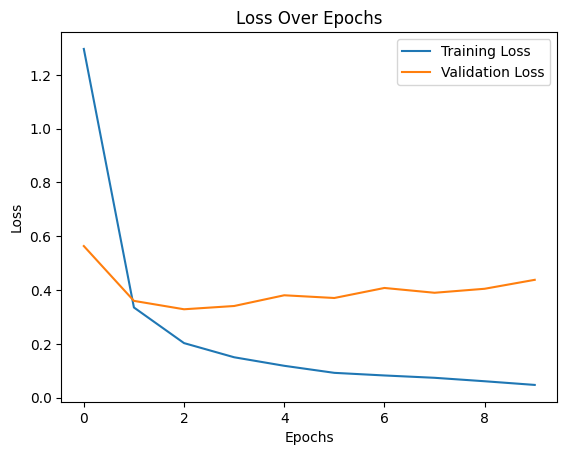

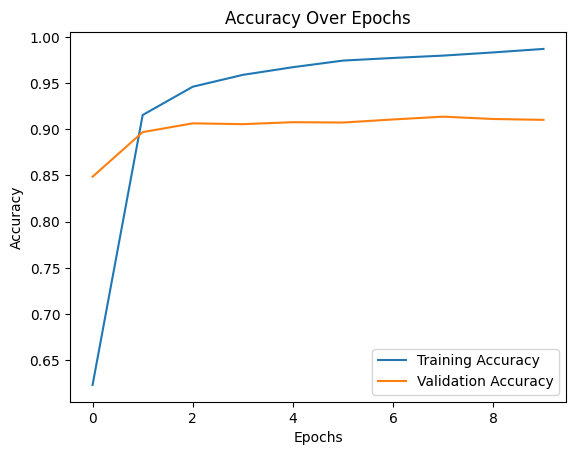

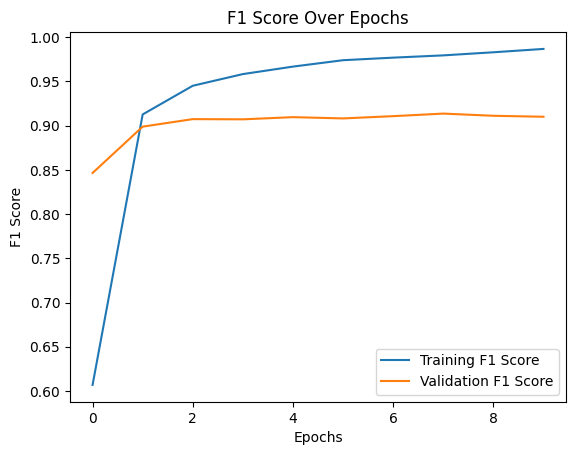

In [ ]:
Report.plot_training_history(history)

## Preparing Features and Labels (Tags) for POS Tagging with MLP

We prepare data for training a Multi-Layer Perceptron (MLP) model to predict Part-of-Speech (POS) tags using sliding window word embeddings.

We use the pre-trained `word2vec-google-news-300` model from Gensim's API to obtain 300-dimensional word embeddings for the words in our dataset.

**Processing Sentences**:
   - The `UtilsPOSTagging.words` function extracts words from the input sentences, and `UtilsPOSTagging.tags` extracts the corresponding POS tags.
   - For each word in a sentence, we retrieve its embedding using `UtilsPOSTagging.get_word_embedding`.
   - The `UtilsPOSTagging.sliding_window` function creates feature vectors by applying a sliding window of a specified size (`window_size`=3) over word embeddings in each sentence.
   - *Padding*: Zero vectors are added at the start and end of each sentence to ensure the sliding window operates fully on all words.
   - For each word, the embeddings from its surrounding context (based on the window size) are concatenated to form a single feature vector.
   - The POS tag of the center word in the window is used as the label.

**Outputs**:
   - **Features**: A 2D NumPy array where each row is a flattened feature vector of embeddings for a word and its context. Shape: `(number_of_words, window_size * embedding_dim)`.
   - **Tags**: A 1D NumPy array containing the corresponding POS tags (labels) for the center words. Shape: `(number_of_words,)`.

By the end of this process, we have a dataset ready for training the MLP model, with features representing the context of each word and labels indicating their corresponding POS tags.

In [ ]:
window_size = 3


Preprocess and encode tags for sequence labeling tasks using `LabelEncoder` from `sklearn`.

- **Flatten Tag Sequences**: The tag sequences from the training data are flattened to create a single list of all tags.
- **Encode Tags**: The encoder is fitted to generate a mapping from tags to numerical labels.
- **Transform Datasets**: Tags in the training, development, and test sets are converted into numerical formats for model compatibility.
- **Create Tag-to-Integer Mapping**: A dictionary (`tag_to_int`) maps each tag to its corresponding numerical value, making it easier to interpret and debug.



In [ ]:
all_tags = [tag for sentence in train_as_tags for tag in sentence]
tag_encoder = LabelEncoder()
tag_encoder.fit(all_tags)

LabelEncoder()

In [ ]:
# Convert tags to numerical labels for the training set
train_labels_numerical = [tag_encoder.transform(sentence) for sentence in train_as_tags]
dev_labels_numerical = [tag_encoder.transform(sentence) for sentence in dev_as_tags]
test_labels_numerical = [tag_encoder.transform(sentence) for sentence in test_as_tags]

tag_to_int = dict(zip(tag_encoder.classes_, tag_encoder.transform(tag_encoder.classes_)))
print(tag_to_int)

{'ADJ': 0, 'ADP': 1, 'ADV': 2, 'AUX': 3, 'CCONJ': 4, 'DET': 5, 'INTJ': 6, 'NOUN': 7, 'NUM': 8, 'PART': 9, 'PRON': 10, 'PROPN': 11, 'PUNCT': 12, 'SCONJ': 13, 'SYM': 14, 'VERB': 15, 'X': 16}


In [ ]:
train_features, train_labels = UtilsPOSTagging.sliding_window(train_as_embed, train_as_tags, window_size=3)
dev_features, dev_labels = UtilsPOSTagging.sliding_window(dev_as_embed, dev_as_tags, window_size=3)
test_features, test_labels = UtilsPOSTagging.sliding_window(test_as_embed, test_as_tags, window_size=3)

### **POS Tagging with MLP Classifier**

**Experiment Setup: Initial Testing with Arbitrary Hyperparameters**

In this experiment, we aim to evaluate the performance of our POS Tagger classifier. To start, we set arbitrary hyperparameter values. This initial testing allows us to observe baseline performance and helps us identify potential adjustments for further tuning. Subsequent steps will involve tuning these parameters for optimal performance.

In [ ]:
input_size = 900
# Model instance
model = MLPModel(input_size=input_size, hidden_sizes=[512, 256], output_size=len(tag_encoder.classes_), dropout_probs=0.5)
print(model)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Optimizer and loss function
optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Number of epochs
epochs = 5

MLPModel(
  (layers): ModuleList(
    (0): Linear(in_features=900, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
  )
  (dropouts): ModuleList(
    (0-1): 2 x Dropout(p=0.5, inplace=False)
  )
  (output_layer): Linear(in_features=256, out_features=17, bias=True)
)


In [ ]:
train_labels_flattened = [label for sentence in train_labels_numerical for label in sentence]
dev_labels_flattened = [label for sentence in dev_labels_numerical for label in sentence]
test_labels_flattened = [label for sentence in test_labels_numerical for label in sentence]


In [ ]:
train_features_tensor = torch.tensor(train_features, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels_flattened, dtype=torch.long)
train_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

dev_features_tensor = torch.tensor(dev_features, dtype=torch.float32)
dev_labels_tensor = torch.tensor(dev_labels_flattened, dtype=torch.long)
dev_dataset = TensorDataset(dev_features_tensor, dev_labels_tensor)
dev_loader = DataLoader(dev_dataset, batch_size=32)

test_features_tensor = torch.tensor(test_features, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels_flattened, dtype=torch.long)
test_dataset = TensorDataset(test_features_tensor, test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
# Train and evaluate the MLP Classifier (Before hyperparameter tuning)
test_accuracy, macro_f1 = UtilsMLP.train_and_validate(model, optimizer, criterion, device, epochs, train_loader, test_loader)

Epoch 1/5, Training Loss: 0.5630, Accuracy: 0.8243, F1 Score: 0.8197
Validation Loss: 0.4538, Accuracy: 0.8552, F1 Score: 0.8503
Epoch 2/5, Training Loss: 0.4407, Accuracy: 0.8593, F1 Score: 0.8560
Validation Loss: 0.4310, Accuracy: 0.8601, F1 Score: 0.8543
Epoch 3/5, Training Loss: 0.4076, Accuracy: 0.8684, F1 Score: 0.8656
Validation Loss: 0.4246, Accuracy: 0.8633, F1 Score: 0.8607
Epoch 4/5, Training Loss: 0.3870, Accuracy: 0.8737, F1 Score: 0.8712
Validation Loss: 0.4298, Accuracy: 0.8624, F1 Score: 0.8580
Epoch 5/5, Training Loss: 0.3711, Accuracy: 0.8779, F1 Score: 0.8757
Validation Loss: 0.4202, Accuracy: 0.8638, F1 Score: 0.8594
Training complete! Total time: 39.91 seconds


**Hyperparameter Tuning for MLP Classifier**

The hyperparameter tuning is performed using a grid search approach.

**Hyperparameters Tuned**
- **Hidden Layer Sizes**: The architecture of the MLP, specifying the number of hidden layers and their sizes.
- **Dropout Probabilities**: Regularization parameter controlling the fraction of neurons dropped during training.
- **Learning Rate**: The step size for the optimizer during weight updates.

**Procedure**
1. **Data Preparation**:
   - For each configuration, the input data is reduced to a specific dimensionality, converted into tensors, and prepared using data loaders.
2. **Model Initialization**:
   - An MLP is created using the specified parameters, including input size, hidden layer sizes, and dropout probabilities.
3. **Training**:
   - The model is trained with the Adam optimizer and cross-entropy loss for a fixed number of epochs (50 epochs).
4. **Evaluation**:
   - The model is evaluated on the development set, with the macro F1 score used as the performance metric.

The best-performing set of hyperparameters is identified by iterating through all possible combinations and selecting the one that maximizes the development set's macro F1 score. The final results include the best hyperparameters and their associated performance.


In [ ]:
param_grid = {
    "hidden_sizes": [[256, 128], [512, 256], [512, 256, 128], [512, 256, 128, 64]],
    "dropout_probs": [0.2, 0.3,0.5],
    "learning_rate": [0.001, 0.01]
}

best_score = 0
best_params = None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for params in ParameterGrid(param_grid):
    print(f"Testing parameters: {params}")

    # Unpack parameters
    hidden_sizes = params["hidden_sizes"]
    dropout_probs = params["dropout_probs"]
    learning_rate = params["learning_rate"]
    epochs = 10

    model = MLPModel(input_size=input_size, hidden_sizes=hidden_sizes, output_size=len(tag_encoder.classes_), dropout_probs=dropout_probs)
    optimizer = Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Train and evaluate
    dev_accuracy, dev_macroF1_score = UtilsMLP.train_and_evaluate(model, optimizer, criterion, device, epochs, train_loader, dev_loader, title='Development')

    # Update best parameters if current model is better, according to macro f1 score
    if dev_macroF1_score > best_score:
        best_score = dev_macroF1_score
        best_params = params

print(f"Best hyperparameters: {best_params}")
print(f"Best development macro f1: {best_score:.4f}")

Testing parameters: {'dropout_probs': 0.2, 'hidden_sizes': [256, 128], 'learning_rate': 0.001}
Epoch [1/10], Average Loss: 0.5224
Epoch [2/10], Average Loss: 0.3856
Epoch [3/10], Average Loss: 0.3421
Epoch [4/10], Average Loss: 0.3111
Epoch [5/10], Average Loss: 0.2886
Epoch [6/10], Average Loss: 0.2701
Epoch [7/10], Average Loss: 0.2556
Epoch [8/10], Average Loss: 0.2459
Epoch [9/10], Average Loss: 0.2352
Epoch [10/10], Average Loss: 0.2277
Development Accuracy: 0.8665
Development F1 Score: 0.7764
Testing parameters: {'dropout_probs': 0.2, 'hidden_sizes': [256, 128], 'learning_rate': 0.01}
Epoch [1/10], Average Loss: 0.7351
Epoch [2/10], Average Loss: 0.6776
Epoch [3/10], Average Loss: 0.6573
Epoch [4/10], Average Loss: 0.6469
Epoch [5/10], Average Loss: 0.6409
Epoch [6/10], Average Loss: 0.6429
Epoch [7/10], Average Loss: 0.6414
Epoch [8/10], Average Loss: 0.6377
Epoch [9/10], Average Loss: 0.6313
Epoch [10/10], Average Loss: 0.6302
Development Accuracy: 0.8287
Development F1 Score: 

In [ ]:

best_hidden_sizes = best_params["hidden_sizes"]
best_dropout_probs = best_params["dropout_probs"]
best_learning_rate = best_params["learning_rate"]
best_epochs = epochs
model = MLPModel(input_size, best_hidden_sizes, len(tag_encoder.classes_), best_dropout_probs)
print(model)
model.to(device)

optimizer = Adam(model.parameters(), lr=best_learning_rate)
criterion = nn.CrossEntropyLoss()

# Train and validate
epochs_for_val = 100
history, best_model_path = UtilsMLP.train_and_validate(model, optimizer, criterion, device, epochs_for_val, train_loader, dev_loader)
print(f"Best model saved at: {best_model_path}")

MLPModel(
  (layers): ModuleList(
    (0): Linear(in_features=900, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
  )
  (dropouts): ModuleList(
    (0-1): 2 x Dropout(p=0.2, inplace=False)
  )
  (output_layer): Linear(in_features=256, out_features=17, bias=True)
)
Epoch 1/100, Training Loss: 0.4933, Accuracy: 0.8425, F1 Score: 0.8388
Validation Loss: 0.4280, Accuracy: 0.8613, F1 Score: 0.8581
Epoch 2/100, Training Loss: 0.3619, Accuracy: 0.8806, F1 Score: 0.8781
Validation Loss: 0.4168, Accuracy: 0.8666, F1 Score: 0.8628
Epoch 3/100, Training Loss: 0.3099, Accuracy: 0.8950, F1 Score: 0.8935
Validation Loss: 0.4239, Accuracy: 0.8677, F1 Score: 0.8655
Epoch 4/100, Training Loss: 0.2742, Accuracy: 0.9059, F1 Score: 0.9049
Validation Loss: 0.4371, Accuracy: 0.8688, F1 Score: 0.8652
Epoch 5/100, Training Loss: 0.2482, Accuracy: 0.9146, F1 Score: 0.9139
Validation Loss: 0.4799, Accuracy: 0.8676, F1 Score: 0.8627
Epoch 6/100, Training Loss: 0.2294, 

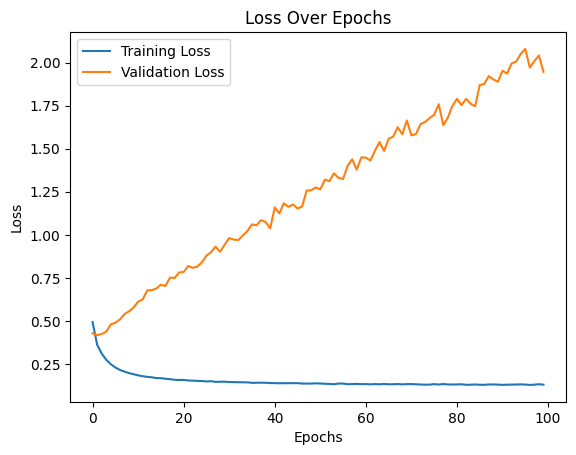

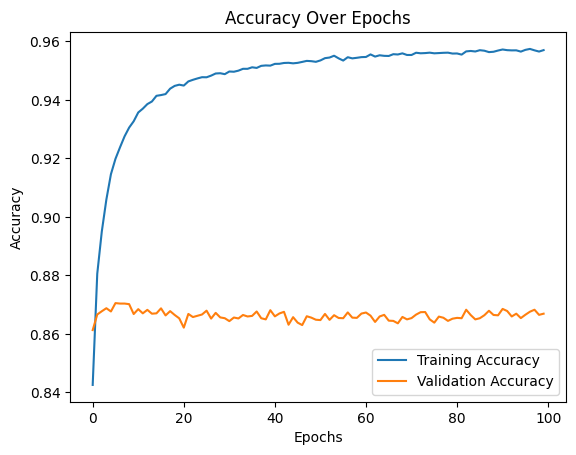

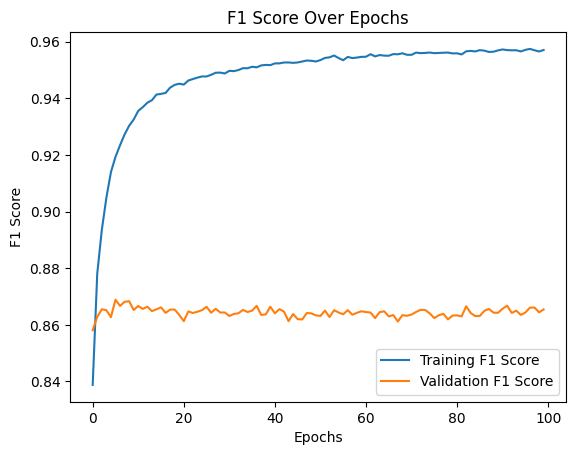

In [ ]:
Report.plot_training_history(history)

## Comparisons

In this section, we evaluate the performance of three models:

## 1. **Best BiLSTM Model**
   - After performing hyperparameter tuning on the BiLSTM model with attention, we use the configuration that achieved the highest macro F1 score on the validation set.
   - This model leverages pre-trained word embeddings (e.g., Word2Vec) and incorporates an attention mechanism to improve context understanding.
   - The BiLSTM model captures long-term dependencies and sequential patterns, making it well-suited for POS tagging tasks.

---

## 2. **Best MLP Model**:
   - After conducting hyperparameter tuning on the MLP model, we use the configuration that achieved the best performance on the validation set. This model utilizes sliding window word embeddings.

---

## 3. **Baseline Classifier**:
   - As a reference point, we implement a baseline classifier that operates as follows:
     - For each word in the test set, it assigns the **most frequent tag** that the word had in the training data.
     - For words not encountered during training (unseen words), the classifier assigns the **most frequent tag overall** (across all words) from the training data.

This baseline provides a simple yet effective method for POS tagging and serves as a comparison to demonstrate the improvements achieved by the MLP model.

### **BILSTM**

In [ ]:
model2 = BiLSTM_Attention(
        input_dim=embedding_dim,
        n_classes=len(tag2idx),
        dropout_prob_emb=best_dropout_prob_emb,
        dropout_prob_att=best_dropout_prob_att,
        dropout_prob_out=best_dropout_prob_out,
        hidden_dim=128,
        lstm_hidden_dim=best_lstm_hidden_dim,
        lstm_stacks=best_lstm_stacks,
        attention_hidden_sizes=best_attention_hidden_sizes,
        max_words=len(word2idx),
        matrix_embeddings=embedding_matrix,
    )
model2.to(device)

# Define optimizer and criterion
optimizer = Adam(model2.parameters(), lr=best_learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=0)

In [ ]:
trained_model = TrainEvaluate.train_model(model2, optimizer, criterion, device, 2, train_loader)

Epoch 1/2, Loss: 0.0696
Epoch 2/2, Loss: 0.0598


In [ ]:
predictions = TrainEvaluate.predict(trained_model, X_train_padded, device)
print("Predicted Labels:")
print(predictions)
true_labels = y_train_padded.argmax(axis=-1).flatten()  # Convert from one-hot

# Mask out padding tokens
valid_true_labels = true_labels[true_labels != PAD_INDEX]
valid_predictions = predictions[true_labels != PAD_INDEX]

# Evaluate
print("Accuracy:", accuracy_score(valid_true_labels, valid_predictions))
print("F1 Score:", f1_score(valid_true_labels, valid_predictions, average='weighted'))
print("Classification Report:")
print(classification_report(valid_true_labels, valid_predictions))


Accuracy: 0.9890420332355816
F1 Score: 0.9889772449536427
Classification Report:
              precision    recall  f1-score   support

           1       0.99      0.99      0.99     34755
           2       0.99      0.99      0.99     17738
           3       1.00      1.00      1.00     12817
           4       0.99      0.94      0.97       695
           5       0.99      1.00      1.00     23596
           6       0.95      0.97      0.96      3822
           7       0.93      0.69      0.79       399
           8       0.99      0.99      0.99     22602
           9       1.00      1.00      1.00     18677
          10       0.97      0.96      0.97      4127
          11       0.99      0.97      0.98     10117
          12       1.00      0.99      1.00      5747
          13       1.00      1.00      1.00      6687
          14       1.00      1.00      1.00     16299
          15       0.99      0.99      0.99     13187
          16       0.96      0.97      0.97     12613


In [ ]:
trained_model = TrainEvaluate.train_model(model2, optimizer, criterion, device, 2, train_loader)
eval_report = TrainEvaluate.evaluate_model(trained_model, criterion, device, test_loader)

Epoch 1/2, Loss: 0.0754
Epoch 2/2, Loss: 0.0648
Classification Report:
              precision    recall  f1-score   support

           1       0.93      0.97      0.95      2030
           2       0.99      0.99      0.99       736
           3       0.99      0.97      0.98      3096
           4       0.96      0.96      0.96       649
           5       0.92      0.87      0.90      1794
           6       0.96      0.91      0.93      2606
           7       0.88      0.81      0.84       121
           8       0.92      0.90      0.91      1183
           9       0.87      0.88      0.88      4123
          10       0.00      0.00      0.00        42
          11       0.99      0.98      0.99      1543
          12       0.93      0.84      0.88       384
          13       0.89      0.68      0.77       109
          14       0.66      0.83      0.74      2076
          15       0.87      0.49      0.63       542
          16       0.98      0.99      0.99      1896
          

### **MLP Classifier**

In [ ]:
model = MLPModel(input_size=input_size, hidden_sizes=best_hidden_sizes, output_size=len(tag_encoder.classes_), dropout_probs=best_dropout_probs)
model.to(device)
optimizer = Adam(model.parameters(), lr=best_learning_rate)
criterion = nn.CrossEntropyLoss()
mlp = MLPClassifier(model, optimizer, criterion, device, epochs=2)
_ = mlp.fit(train_loader)

Epoch [1/2] - Training Loss: 0.4933
Epoch [2/2] - Training Loss: 0.3608


In [ ]:
y_test_mlp = mlp.predict(test_features)
print(classification_report(test_labels_flattened, y_test_mlp))

              precision    recall  f1-score   support

           0       0.92      0.91      0.92      1794
           1       0.83      0.89      0.86      2030
           2       0.94      0.90      0.92      1183
           3       0.97      0.98      0.97      1543
           4       0.62      0.47      0.53       736
           5       0.91      0.93      0.92      1896
           6       0.88      0.82      0.85       121
           7       0.88      0.93      0.90      4123
           8       0.78      0.49      0.60       542
           9       0.84      0.86      0.85       649
          10       0.98      0.99      0.98      2166
          11       0.87      0.59      0.70      2076
          12       0.68      0.87      0.76      3096
          13       0.89      0.80      0.84       384
          14       0.97      0.64      0.77       109
          15       0.95      0.93      0.94      2606
          16       0.50      0.02      0.05        42

    accuracy              

### **Most Frequent Tag Classifier (Baseline)**

In [ ]:
baseline_model = MostFrequentTagBaseline()
baseline_model.fit(train_features, train_labels_flattened)

# Predict for the dev set
test_predicted_tags = baseline_model.predict(test_features)
print(classification_report(test_labels_flattened, test_predicted_tags))

              precision    recall  f1-score   support

           0       0.95      0.21      0.35      1794
           1       0.91      0.23      0.37      2030
           2       0.96      0.27      0.42      1183
           3       0.99      0.40      0.57      1543
           4       0.59      0.17      0.27       736
           5       0.97      0.30      0.46      1896
           6       0.97      0.53      0.68       121
           7       0.24      0.98      0.38      4123
           8       0.60      0.21      0.31       542
           9       0.95      0.33      0.49       649
          10       0.99      0.51      0.67      2166
          11       0.80      0.21      0.33      2076
          12       0.71      0.54      0.61      3096
          13       0.96      0.28      0.43       384
          14       0.88      0.33      0.48       109
          15       0.94      0.30      0.45      2606
          16       0.25      0.02      0.04        42

    accuracy              

In [ ]:
train_labels = y_train_padded.argmax(axis=-1).flatten()  # Convert from one-hot
dev_labels = y_dev_padded.argmax(axis=-1).flatten()
test_labels = y_test_padded.argmax(axis=-1).flatten()


In [ ]:
classes = np.unique(train_labels_flattened)

# Wrap the trained BiLSTM model
bilstm_adapter = BiLSTMAdapter(trained_model, device, batch_size=32)

# Update the estimators dictionary
estimators = {
    'MLPClassifier': mlp,
    'MostFrequentTagBaseline': baseline_model,
    'BiLSTM': bilstm_adapter  # Use the adapter
}
datasets = {
    'Train': ({
        'MLPClassifier': train_features,
        'MostFrequentTagBaseline': train_features,
        'BiLSTM': X_train_padded
    }, {
        'MLPClassifier': train_labels_flattened,
        'MostFrequentTagBaseline': train_labels_flattened,
        'BiLSTM': train_labels
    }),
    'Dev': ({
        'MLPClassifier': dev_features,
        'MostFrequentTagBaseline': dev_features,
        'BiLSTM': X_dev_padded
    }, {
        'MLPClassifier': dev_labels_flattened,
        'MostFrequentTagBaseline': dev_labels_flattened,
        'BiLSTM': dev_labels
    }),
    'Test': ({
        'MLPClassifier': test_features,
        'MostFrequentTagBaseline': test_features,
        'BiLSTM': X_test_padded
    }, {
        'MLPClassifier': test_labels_flattened,
        'MostFrequentTagBaseline': test_labels_flattened,
        'BiLSTM': test_labels
    })
}


# Call the Report function
Report.display_metrics_scores(
    estimators=estimators,
    classes=classes,
    datasets=datasets,
    class_names=tag_to_int
)


,Classifier,Subset,Class,Macro Precision,Macro Recall,Macro F1,Macro PR-AUC,Precision,Recall,F1,PR-AUC
0,MLPClassifier,Train,Macro Average,0.892024,0.819782,0.842762,0.900854,nan,nan,nan,nan
1,MLPClassifier,Train,0,nan,nan,nan,nan,0.960338,0.938273,0.949177,0.985659
2,MLPClassifier,Train,1,nan,nan,nan,nan,0.861011,0.925080,0.891896,0.961534
3,MLPClassifier,Train,2,nan,nan,nan,nan,0.955663,0.918256,0.936586,0.981456
4,MLPClassifier,Train,3,nan,nan,nan,nan,0.983609,0.983225,0.983417,0.997745
5,MLPClassifier,Train,4,nan,nan,nan,nan,0.698323,0.516824,0.594019,0.720782
6,MLPClassifier,Train,5,nan,nan,nan,nan,0.947076,0.962881,0.954913,0.991467
7,MLPClassifier,Train,6,nan,nan,nan,nan,0.901989,0.913669,0.907791,0.952935
8,MLPClassifier,Train,7,nan,nan,nan,nan,0.934762,0.957301,0.945898,0.985170
9,MLPClassifier,Train,8,nan,nan,nan,nan,0.883619,0.686213,0.772504,0.857080


,Classifier,Subset,Class,Macro Precision,Macro Recall,Macro F1,Macro PR-AUC,Precision,Recall,F1,PR-AUC
0,MLPClassifier,Dev,Macro Average,0.812434,0.751128,0.771179,0.832086,nan,nan,nan,nan
1,MLPClassifier,Dev,0,nan,nan,nan,nan,0.932819,0.904431,0.918406,0.966875
2,MLPClassifier,Dev,1,nan,nan,nan,nan,0.815266,0.885672,0.849012,0.933467
3,MLPClassifier,Dev,2,nan,nan,nan,nan,0.925129,0.878268,0.901090,0.959309
4,MLPClassifier,Dev,3,nan,nan,nan,nan,0.972594,0.973835,0.973214,0.993093
5,MLPClassifier,Dev,4,nan,nan,nan,nan,0.609982,0.423620,0.500000,0.638492
6,MLPClassifier,Dev,5,nan,nan,nan,nan,0.908589,0.952105,0.929838,0.980374
7,MLPClassifier,Dev,6,nan,nan,nan,nan,0.796460,0.782609,0.789474,0.842687
8,MLPClassifier,Dev,7,nan,nan,nan,nan,0.871881,0.920940,0.895740,0.949267
9,MLPClassifier,Dev,8,nan,nan,nan,nan,0.775087,0.584856,0.666667,0.736485


,Classifier,Subset,Class,Macro Precision,Macro Recall,Macro F1,Macro PR-AUC,Precision,Recall,F1,PR-AUC
0,MLPClassifier,Test,Macro Average,0.848511,0.765812,0.787352,0.837661,nan,nan,nan,nan
1,MLPClassifier,Test,0,nan,nan,nan,nan,0.924165,0.910256,0.917158,0.959858
2,MLPClassifier,Test,1,nan,nan,nan,nan,0.825730,0.891626,0.857414,0.936331
3,MLPClassifier,Test,2,nan,nan,nan,nan,0.943060,0.896027,0.918942,0.963672
4,MLPClassifier,Test,3,nan,nan,nan,nan,0.973497,0.976021,0.974757,0.993321
5,MLPClassifier,Test,4,nan,nan,nan,nan,0.623188,0.467391,0.534161,0.649454
6,MLPClassifier,Test,5,nan,nan,nan,nan,0.909467,0.927215,0.918255,0.976275
7,MLPClassifier,Test,6,nan,nan,nan,nan,0.883929,0.818182,0.849785,0.902983
8,MLPClassifier,Test,7,nan,nan,nan,nan,0.883264,0.926752,0.904486,0.953391
9,MLPClassifier,Test,8,nan,nan,nan,nan,0.776812,0.494465,0.604284,0.681624
